<a href="https://colab.research.google.com/github/hukim1112/one-day-DL/blob/main/4_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# 1. cifar10 데이터셋 준비

pytorch의 데이터셋 객체는 \_\_getitem\_\_ 메서드를 갖으며, 내부적으로 인덱스로 데이터와 레이블을 리턴한다.

pytorch에서는 다양한 데이터셋 클래스를 구현해두어서 아래와 같이 쉽게 가져와 사용할 수 있다.

만약 내가 소유한 데이터셋를 가져오고 싶을 때는 파이토치 데이터셋 클래스를 상속 받아 내 데이터에 맞게 구현해주면 된다. [Custom 데이터셋 클래스 구현](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)

In [ ]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

val_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [ ]:
labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute([1,2,0])) #[C,H,W] => [H,W,C], axis change
plt.show()

데이터셋 객체는 한 번에 하나의 데이터와 정답을 가져오지만, 학습을 위해 미니배치(minibatch)로 데이터를 가져올 필요가 있다. 또한 과적합을 줄이기 위해 매 epoch마다 데이터의 순서를 섞어(shuffle)주어야 한다.

이를 위해 파이토치는 [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders)를 제공한다.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

In [ ]:
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute([1,2,0]), cmap="gray")
plt.show()
print(f"Label: {labels_map[label.item()]}")

# 2. Convolutional Neural Network 구축해보기

- Pytorch에서 모델을 정의하기 위해 nn.Module 클래스를 상속
- \_\_init\_\_ 함수에서 네트워크의 하위 레이어들을 정의
- forward 함수에서 어떻게 데이터를 통과시킬 것인지 정의


In [ ]:
from torch import nn
from torch.nn.functional import relu, max_pool2d

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [ ]:
def Conv_block(inf, outf):
    return nn.Sequential(
    nn.Conv2d(in_channels=inf, out_channels=outf, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(num_features=outf, momentum=0.1),
    nn.ReLU())

In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.conv_block1 = Conv_block(3, 32)
        self.conv_block2 = Conv_block(32, 32)
        self.conv_block3 = Conv_block(32, 64)
        self.conv_block4 = Conv_block(64, 64)
        self.conv_block5 = Conv_block(64, 128)
        self.conv_block6 = Conv_block(128, 128)
        self.maxpool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(128*8*8, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.maxpool(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.maxpool(x)
        x = self.conv_block5(x)
        x = self.conv_block6(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = ImageClassifier().to(device)
print(model)

In [ ]:
X = torch.rand(1, 3, 32, 32, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train() #모델을 학습모드로,
    total_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) #샘플과 정답을 GPU로 전달
        pred = model(X)
        loss = loss_fn(pred, y) # Compute prediction error
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad() #optimizer의 gradient 초기화
        loss.backward() #loss
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    total_loss /= num_batches
    correct /= size
    return total_loss, correct

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #모델을 평가모드로,
    total_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    total_loss /= num_batches
    correct /= size
    return total_loss, correct

In [ ]:
epochs = 10

train_acc_epoch = []
val_acc_epoch = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    print(f"Train Error: \n Accuracy: {(100*train_acc):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    val_loss, val_acc = test(val_dataloader, model, loss_fn)
    print(f"Validation Error: \n Accuracy: {(100*val_acc):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    train_acc_epoch.append(train_acc)
    val_acc_epoch.append(val_acc)
print("Done!")

In [ ]:
plt.figure(figsize=(14,4))
plt.xlabel("Epochs")
plt.xticks(range(1,len(train_acc_epoch)+1))
plt.ylabel("accuracy")
plt.plot(list(range(1,len(train_acc_epoch)+1)), train_acc_epoch, label='train accuracy')
plt.plot(list(range(1,len(val_acc_epoch)+1)), val_acc_epoch, label='val accuracy')
plt.legend()
plt.show()

# 3.사전학습 모델 활용

더 효율적으로 이미지 분류 모델을 구축하기 위해 사전학습 모델을 활용할 수 있습니다.

- Pretrained model : 이미 대규모 이미지데이터베이스에 학습시킨 모델을 활용합니다.
- EarlyStopping : validation loss가 일정 epoch 동안 줄어들지 않으면, 학습을 정지합니다.
- TensorBoard : [TensorBoard](https://www.tensorflow.org/tensorboard)에서 읽을 수 있는 형태로 학습 로그를 저장합니다.

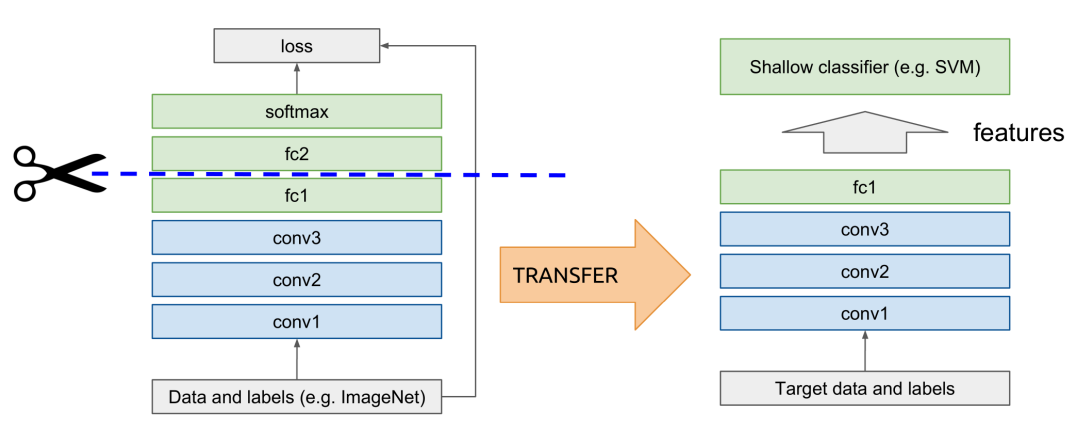

전이학습이란?

전이학습(Transfer Learning)은 **사전학습된 모델(Pretrained Model)**을 가져와 특정 작업에 맞게 **재학습(Fine-Tuning) 또는 일부 조정(Feature Extraction)**하여 사용하는 기법입니다. 즉, 대량의 데이터로 사전학습된 모델의 지식을 새로운 데이터셋으로 전이(Transfer)하여 활용하는 방법입니다. 다음과 같은 장점을 갖습니다.

- 빠른 학습 : 기존 모델이 학습한 일반적인 패턴을 활용하여 적은 데이터로도 빠르게 학습 가능
- 적은 데이터로도 좋은 성능 : 수십만 개의 데이터를 필요로 하는 딥러닝 모델을 적은 데이터로도 학습 가능
- 계산 비용 절감 : 처음부터 모델을 학습할 필요 없이 기존 모델을 활용하여 연산량을 줄일 수 있음
- 과적합(Overfitting) 방지 : 작은 데이터셋에서도 사전학습된 모델이 일반적인 특성을 잘 보존하여 성능이 안정적임



## Pretrained model 사용

In [ ]:
from torchvision import transforms

# 데이터셋을 불러오고 전처리하기 위한 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)), # ResNet은 일반적으로 더 큰 이미지 사이즈를 기대함
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform
)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform
)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)



In [ ]:
import torchvision.models as models

# ResNet18 모델 로드 및 마지막 레이어 수정
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10) # CIFAR10은 10개 클래스를 가짐

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

## 학습 준비

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## 학습에 얼리스타핑 사용

In [ ]:
import numpy as np

class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train() #모델을 학습모드로,
    total_loss, correct, lrs = 0, 0, []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) #샘플과 정답을 GPU로 전달
        pred = model(X)
        loss = loss_fn(pred, y) # Compute prediction error
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad() #optimizer의 gradient 초기화
        loss.backward() #loss
        optimizer.step() #update the parameters

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    total_loss /= num_batches
    correct /= size
    return total_loss, correct, lrs


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #모델을 평가모드로,
    total_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    total_loss /= num_batches
    correct /= size
    return total_loss, correct

In [ ]:
from torch.utils.tensorboard import SummaryWriter

epochs = 10
writer = SummaryWriter(comment="pytorch-experiment#1") #tensorboard에 학습로그 기록
ckpt_path = os.path.dirname(writer.get_logdir())
early_stopping = EarlyStopping(patience = 10, verbose = True, path=os.path.join(ckpt_path ,'resnet-finetuning.pt'))

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc, lrs = train(train_dataloader, model, loss_fn, optimizer)
    print(f"Train Error: \n Accuracy: {(100*train_acc):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    val_loss, val_acc = test(val_dataloader, model, loss_fn)
    print(f"Validation Error: \n Accuracy: {(100*val_acc):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    writer.add_scalar('Loss/train', train_loss, t)
    writer.add_scalar('Loss/val', val_loss, t)
    writer.add_scalar('Accuracy/train', train_acc, t)
    writer.add_scalar('Accuracy/val', val_acc, t)

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
print("Done!")

모델 로드

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model.to(device)

model.load_state_dict(torch.load('runs/resnet-finetuning.pt'))
model.eval()

## 텐서보드를 통한 학습 로그데이터 관리

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/